# Dataset analysis

In [3]:
cd /mnt/sda/otani/Experiments/moment_retrieval/

/mnt/sda/otani/Experiments/moment_retrieval


In [15]:
%matplotlib inline
import matplotlib as mpl
from typing import List
import json
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from src.toolbox.utils import _nms, sentence2token, _load_top_actions
from src.toolbox.eval import evaluate, location_error, accumulate_metrics, categorize_results, summarize_results_per_class
from src.toolbox.visualization import plot_performance_per_class
from src.toolbox.data_converters import ActivityNetCap2Instances
from src.toolbox.baseline import SegmentGeneratorKDE, predict
import seaborn as sns

In [7]:
raw_data = json.load(open("data/raw/ActivityNet/train.json"))
train_data = ActivityNetCap2Instances(raw_data)

In [8]:
def get_key_tokens(sentences: List[str]):
    simplified_sentences = []

    for i, sentence in enumerate(sentences):
        key_tokens = sentence2token(sentence)
        simplified_sentences.append(key_tokens)
        
    return simplified_sentences

sentences = [query[1] for query, _ in train_data]
tokens = [sentence2token(x) for x in sentences]

top-30 actions cover 51.4% of all actions


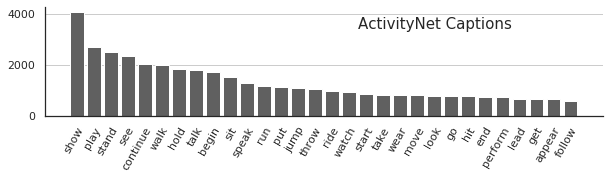

In [153]:
from collections import Counter

# verbs = sum([x[0] for x in simplified_sentences], [])
# verb_c = Counter(verbs)
# k = 30

# counts = [v for _, v in verb_c.most_common(k)]
# top_actions = [k for k, _ in verb_c.most_common(k)]
sns.set_style("white")
plt.figure(figsize=(10, 2))
plt.bar(range(len(counts)), counts, color="#606060")
_ = plt.xticks(np.arange(len(counts))+.5, top_actions, rotation=60, fontsize=11, ha="right")
# plt.title(f"Top-{k} verb vocabulary")
sns.despine()
print(f"top-{k} actions cover {sum(counts)/sum(verb_c.values())*100:.1f}% of all actions")
plt.gca().yaxis.grid()
plt.text(0.7, 0.8, "ActivityNet Captions", fontsize=15, transform=plt.gca().transAxes, ha="center")
plt.savefig("reports/figures/dataset visualization/activitynet-action-vocab.pdf",
           bbox_inches="tight")

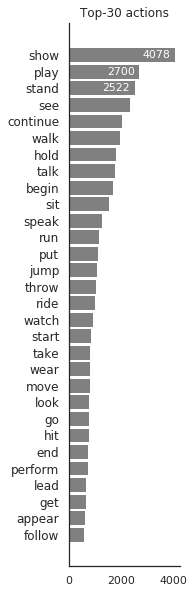

In [133]:
plt.figure(figsize=(2, 10))
bars = plt.barh(range(len(counts)), counts, color="gray", height=.9)
_ = plt.yticks(range(len(counts)), top_actions, fontsize=12)
plt.title(f"Top-{k} actions")
plt.gca().invert_yaxis()

for bar in bars[:3]:
    plt.text(
        bar.get_x()+bar.get_width()-700,
        bar.get_y()+bar.get_height()*.5,
        f"{bar.get_width()}",
        horizontalalignment="center",
        verticalalignment="center",
        fontsize=11,
        color="w"
    )
sns.despine()
plt.savefig("reports/figures/dataset visualization/activitynet-action-vocab-hbar.pdf",
           bbox_inches="tight")

4078

2.06325325352075


(array([1.4347e+04, 1.1400e+04, 6.9110e+03, 3.1740e+03, 1.1310e+03,
        3.7600e+02, 4.8000e+01, 1.8000e+01, 8.0000e+00, 8.0000e+00]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <a list of 10 Patch objects>)

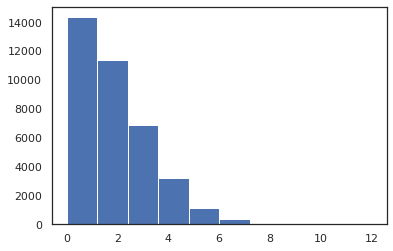

In [34]:
actions_per_query = [len(x[0]) for x in simplified_sentences]
print(np.mean(actions_per_query))
plt.hist(actions_per_query)

# Example

('v_nB90Q8sTBgE', 'A man is seen speaking to the camera and holding up a paper.') (0, 39.98, 210.44)


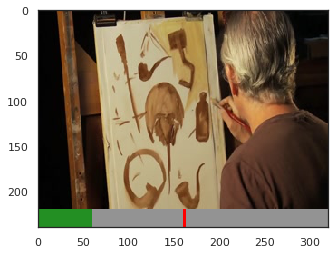

In [81]:
from random import choice as rchoice
from skvideo.io import vread, vwrite
import matplotlib.colors as mcolors
import os

instence = rchoice(train_data)
gt_q, gt_location = instence

frame_dir = f"data/raw/ActivityNet/activitynet_frames/{gt_q[0]}"
frame_files = os.listdir(frame_dir)
frame_files.sort()

vid_arr = np.stack([plt.imread(f"{frame_dir}/{x}") for x in frame_files])

N, H, W, C = vid_arr.shape

fps = N / gt_location[-1]

gt_start_sec, gt_end_sec, duration = gt_location

gt_start_i = gt_start_sec / duration * W
gt_end_i = gt_end_sec / duration * W

time_line = np.zeros((N, 20, W, C))
time_line[:, :, int(gt_start_i):int(gt_end_i), :] += np.asarray(mcolors.to_rgb(mcolors.CSS4_COLORS["limegreen"])) * 255 * .7
time_line[np.where(time_line==0)] = 147.7
step = 1 / N * W
for n in range(N):
    time_line[n, :, int(step * n): int(step*n+3), :] = [255, 0, 0]

vid_arr[:, -20:, :, :] = time_line
plt.imshow(vid_arr[int(N/2)])
print(gt_q, gt_location)

In [90]:
import shutil

for fn in frame_files[::100]:
    shutil.copyfile(f"{frame_dir}/{fn}", f"data/tmp/{fn}")
    print(fn)

000001.jpg
000101.jpg
000201.jpg
000301.jpg
000401.jpg
000501.jpg
000601.jpg
000701.jpg
000801.jpg
000901.jpg
001001.jpg


# Check location prior

fitting...
done


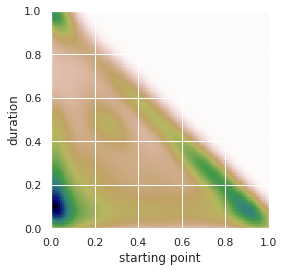

In [8]:
show_prior(train_data)

# Check baseline performance

In [20]:
segment_generator = SegmentGeneratorKDE()
segment_generator.fit("base", train_data)

#instances: 37421


In [21]:
raw_data = json.load(open("data/raw/ActivityNet/val_2.json"))
test_data = ActivityNetCap2Instances(raw_data)

In [ ]:
predict(segment_generator, test_data, nms_threshold=0.5)

In [13]:
# use overall prior
predictions = []
for instance in test_data:
    query, location = instance
    length = location[-1]
    
    samples, likelifood = segment_generator.sample("base", 100)

    bbox = samples.copy()
    bbox[:, 1] = bbox.sum(axis=1)

    keep = _nms(bbox, likelifood, thresh=0.5, top_k=10)
    bbox = bbox[keep]
    likelifood = likelifood[keep]

    location = np.hstack([bbox * length, np.ones((len(bbox),1)) * length])
    
    predictions.append((query, location.tolist(), likelifood.tolist()))
    
    if len(predictions) % 100 == 0:
        print(len(predictions))
        
results = evaluate(test_data, predictions)
summary = accumulate_metrics(results)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
R@1 IoU>0.3 0.19
R@1 IoU>0.5 0.11
R@1 IoU>0.7 0.04
R@5 IoU>0.3 0.44
R@5 IoU>0.5 0.28
R@5

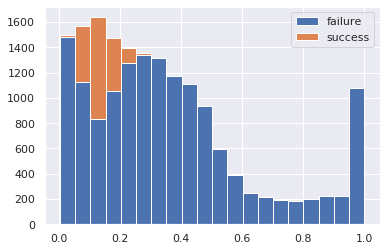

In [14]:
failure = []
success = []
for r, gt_dat in zip(results, test_data):
    _, (s, e, l) = gt_dat
    duration = (e - s) / l
    is_succeed = r[-1]['R@1 IoU>0.5']
    if is_succeed:
        success.append(duration)
    else:
        failure.append(duration)

plt.hist([failure, success], bins=20, stacked=True, label=["failure", "success"])
plt.legend()

In [28]:
import spacy
nlp = spacy.load("en_core_web_sm")

def sentence2token(sentence: str) -> Tuple[List[str], List[str]]:
    tokens = nlp(sentence)

    verb_word = []
    obj_word = []

    for token in tokens:
        if token.is_stop:
            continue

        if token.text == 'person':
            continue

        if token.tag_[:2] == 'VB':
            verb_word.append(token.lemma_)

        if token.tag_ in ['NN', 'NNS']:
            obj_word.append(token.lemma_)

    key_tokens = (verb_word, obj_word)

    return key_tokens

def get_key_tokens(sentences: List[str]):
    simplified_sentences = []

    for i, sentence in enumerate(sentences):
        key_tokens = sentence2token(sentence)
        simplified_sentences.append(key_tokens)
        
    return simplified_sentences

In [29]:
sentences = [query[-1] for query, _ in train_data]
simplified_sentences = get_key_tokens(sentences)

0.6242406973280317

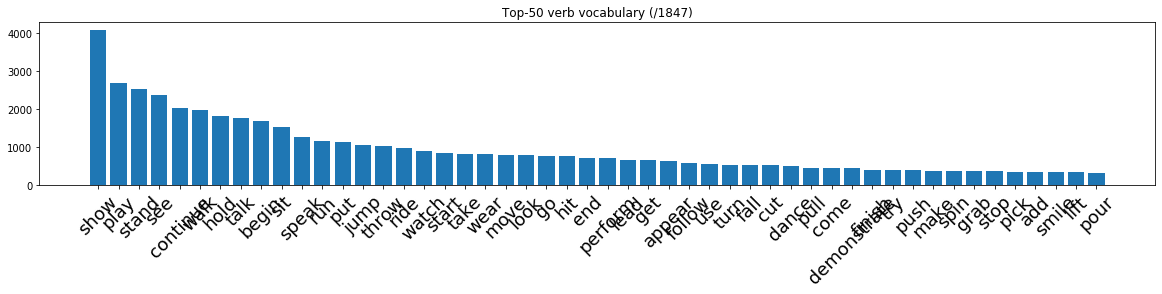

In [30]:
from collections import Counter

verbs = sum([x[0] for x in simplified_sentences], [])
verb_c = Counter(verbs)
k = 50

counts = [v for _, v in verb_c.most_common(k)]
top_actions = [k for k, _ in verb_c.most_common(k)]
plt.figure(figsize=(20, 3))
plt.bar(range(len(counts)), counts)
_ = plt.xticks(range(len(counts)), top_actions, rotation=45, fontsize=18)
plt.title(f"Top-{k} verb vocabulary (/{len(verb_c)})")

sum(counts)/sum(verb_c.values())

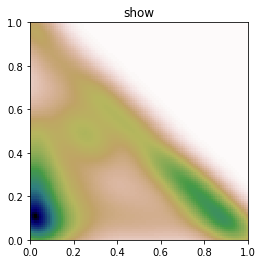

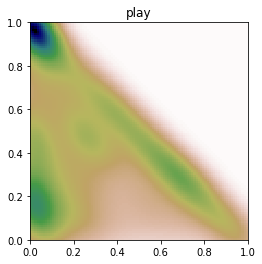

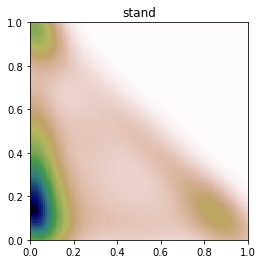

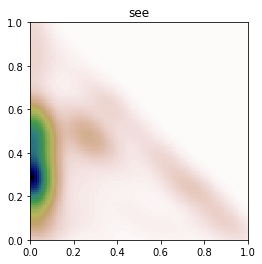

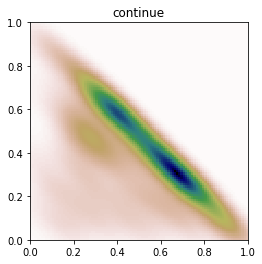

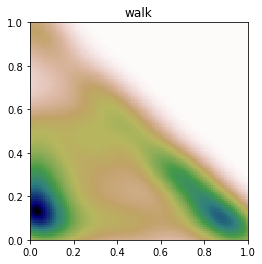

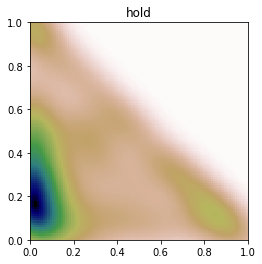

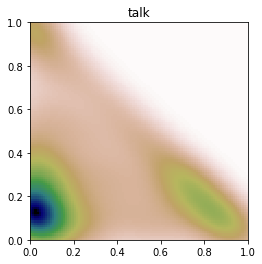

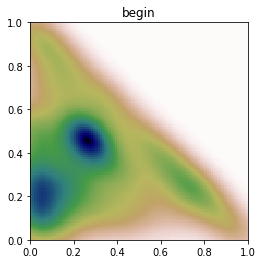

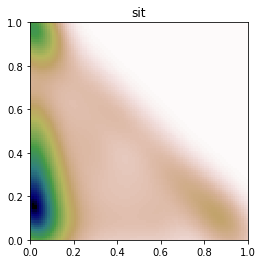

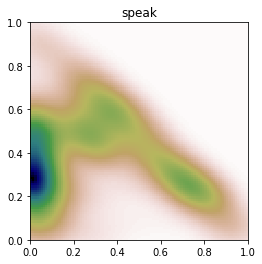

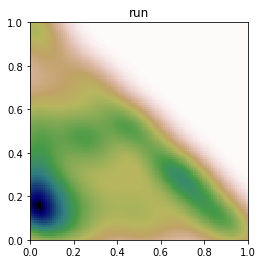

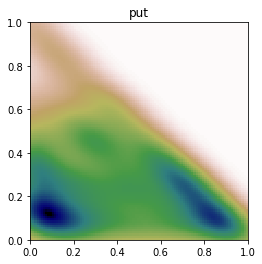

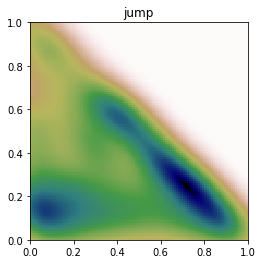

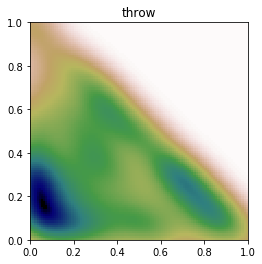

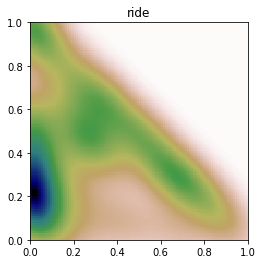

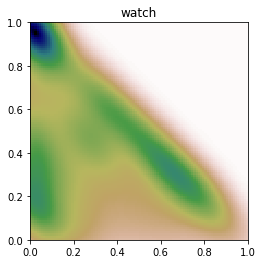

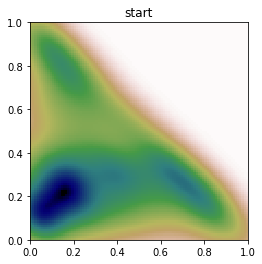

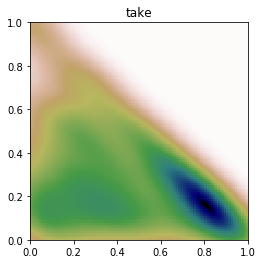

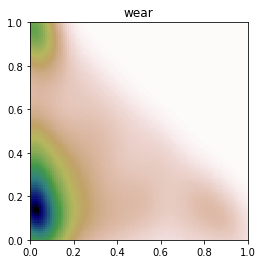

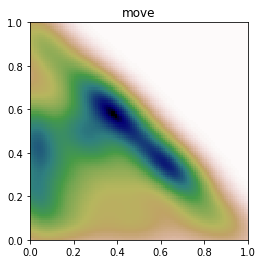

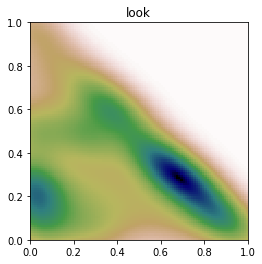

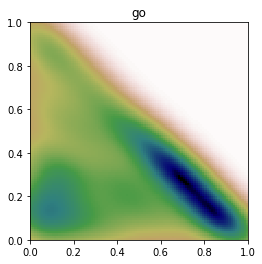

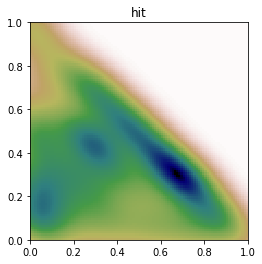

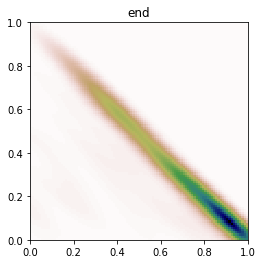

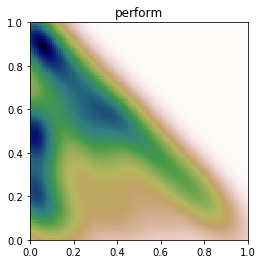

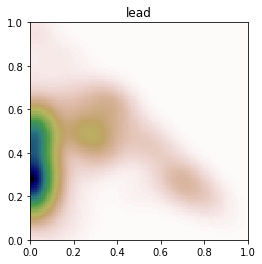

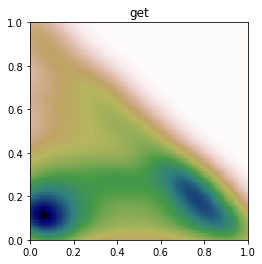

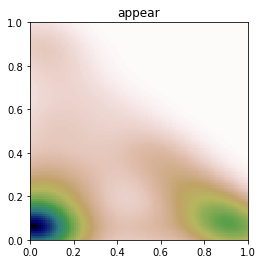

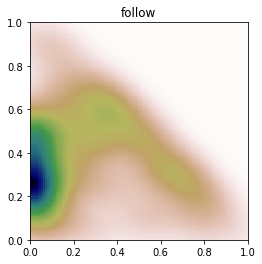

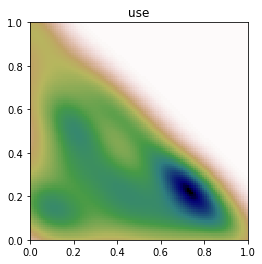

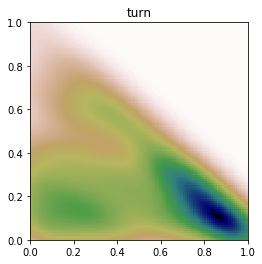

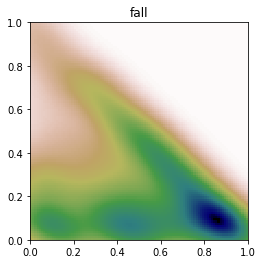

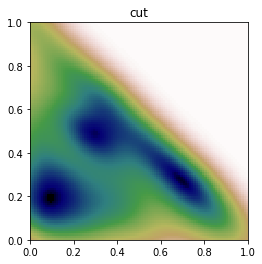

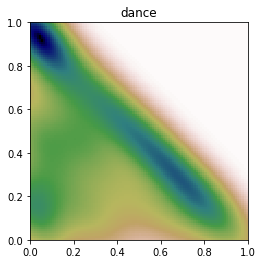

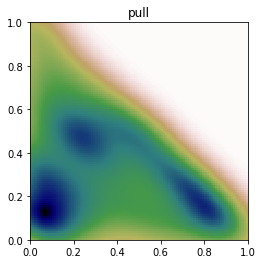

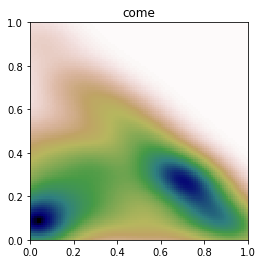

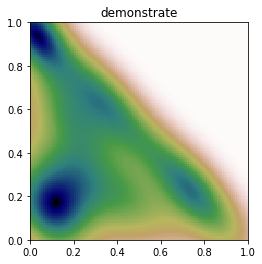

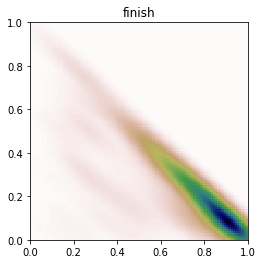

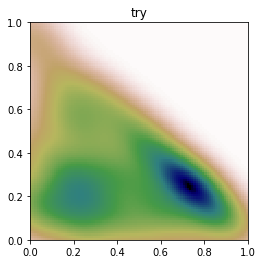

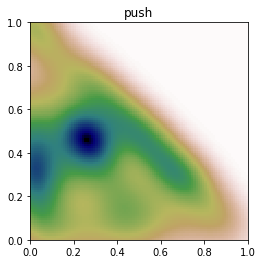

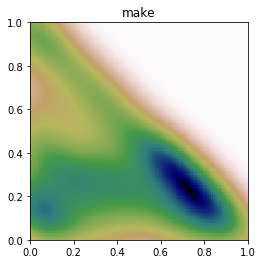

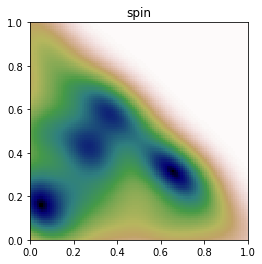

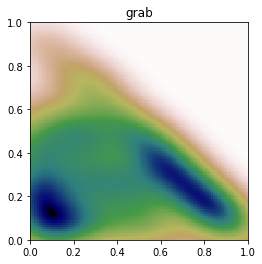

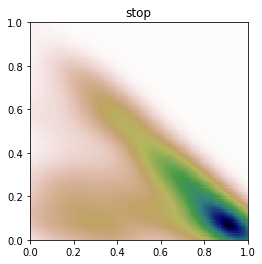

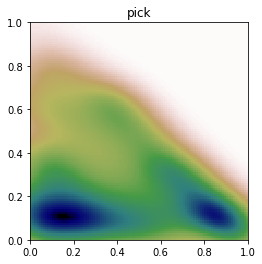

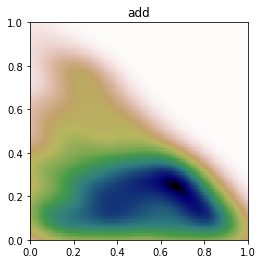

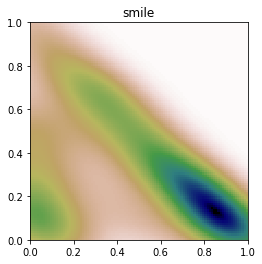

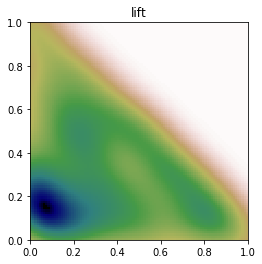

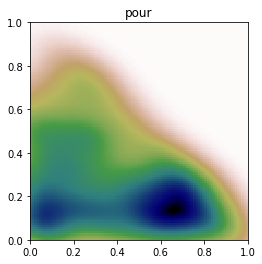

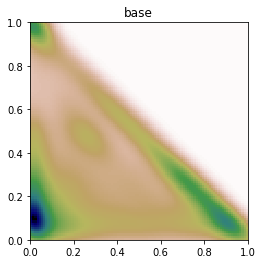

In [96]:
for action, kernel in segment_generator.kernels.items():
    X, Y = np.mgrid[0:1:100j, 0:1:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kernel(positions).T, X.shape)
    plt.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[0, 1, 0, 1])
    plt.title(action)
    plt.show()

0.41898377390111985

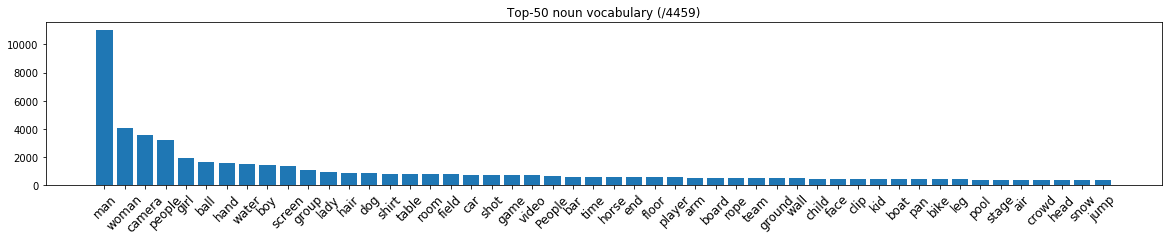

In [32]:
nouns = sum([x[1] for x in simplified_sentences], [])
noun_c = Counter(nouns)
k = 50
counts = [v for _, v in noun_c.most_common(k)]
top_objs = [k for k, _ in noun_c.most_common(k)]
plt.figure(figsize=(20, 3))
plt.bar(range(len(counts)), counts)
_ = plt.xticks(range(len(counts)), top_objs, rotation=45, fontsize=12)
plt.title(f"Top-{k} noun vocabulary (/{len(noun_c)})")

sum(counts)/sum(noun_c.values())

In [13]:
segment_generator = SegmentGeneratorKDE()
for action in _load_top_actions("activitynet"):
    indices = [i for i, query in enumerate(tokens) if action in query[0]]
    sub_train = [train_data[i] for i in indices]
    segment_generator.fit(action, sub_train)
segment_generator.fit("base", train_data)

#instances: 3930
#instances: 2589
#instances: 2475
#instances: 2354
#instances: 2004
#instances: 1918
#instances: 1787
#instances: 1741
#instances: 1672
#instances: 1504
#instances: 1242
#instances: 1129
#instances: 1109
#instances: 1041
#instances: 1008
#instances: 952
#instances: 908
#instances: 839
#instances: 812
#instances: 801
#instances: 767
#instances: 774
#instances: 757
#instances: 736
#instances: 723
#instances: 710
#instances: 655
#instances: 647
#instances: 592
#instances: 578
#instances: 567
#instances: 536
#instances: 527
#instances: 517
#instances: 502
#instances: 450
#instances: 451
#instances: 443
#instances: 395
#instances: 391
#instances: 391
#instances: 385
#instances: 375
#instances: 373
#instances: 371
#instances: 350
#instances: 333
#instances: 347
#instances: 339
#instances: 326
#instances: 37421


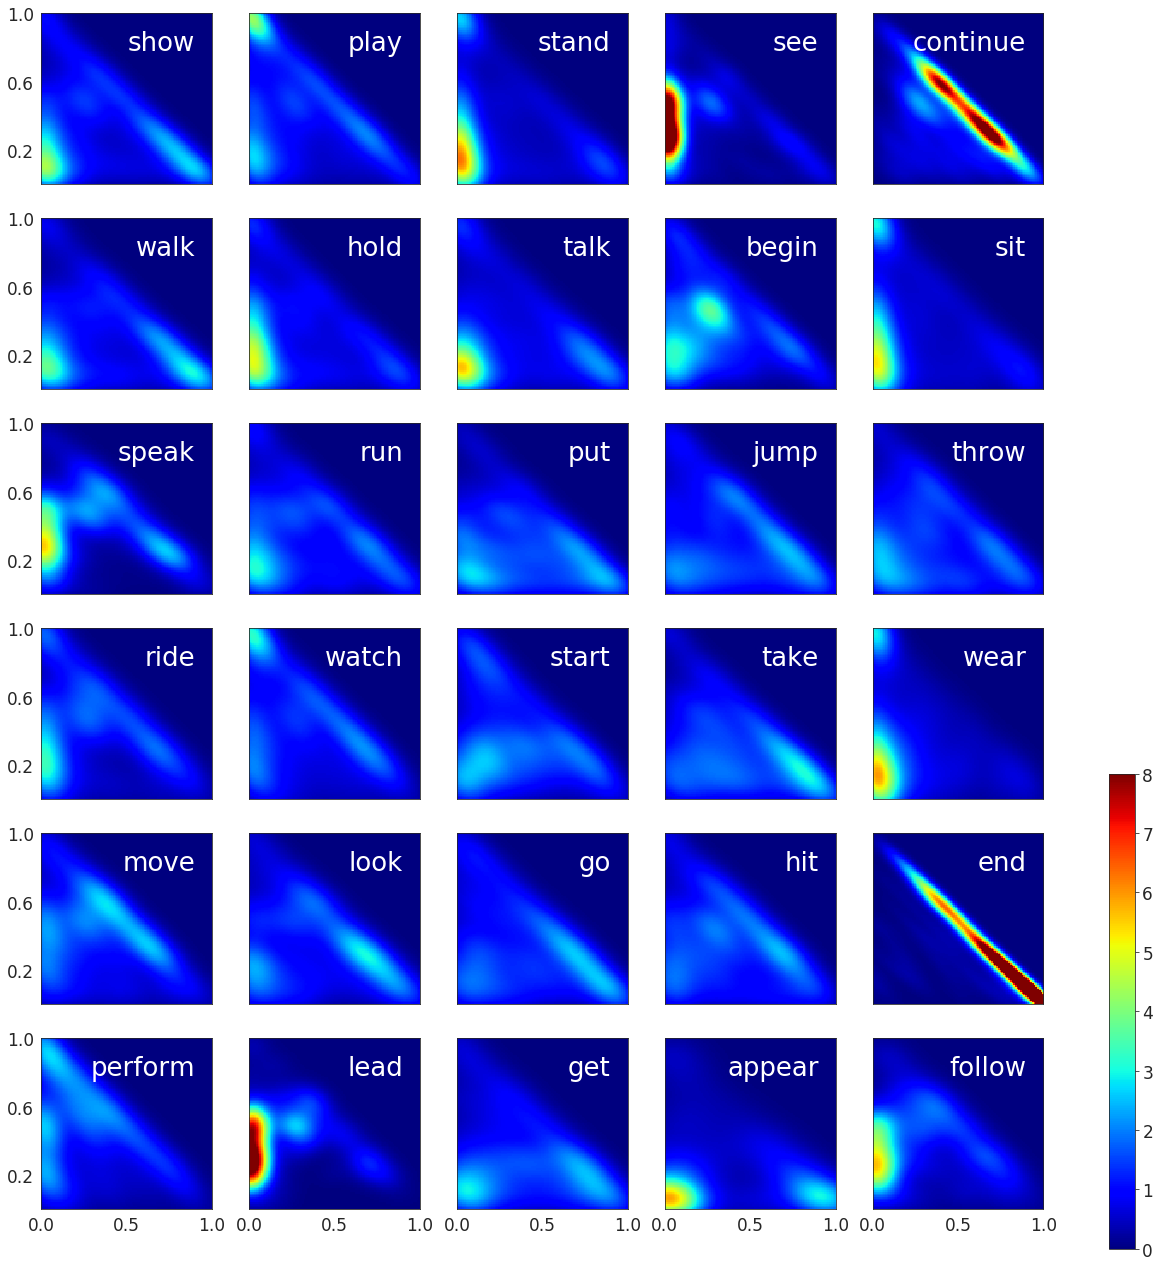

In [29]:
with mpl.rc_context(rc={'font.size': 17}):
    f, axes = plt.subplots(6, 5, figsize=(18, 22))
    axes = axes.ravel()
    for i, (action, kernel) in enumerate(segment_generator.kernels.items()):
        if i==len(axes):
            break
        X, Y = np.mgrid[0:1:100j, 0:1:100j]
        positions = np.vstack([X.ravel(), Y.ravel()])
        Z = np.reshape(kernel(positions).T, X.shape)
        im = axes[i].imshow(np.rot90(Z), cmap=plt.cm.jet, extent=[0, 1, 0, 1], vmin=0, vmax=8)
        axes[i].text(0.9, 0.9, action, ha='right', va='top', color='w', fontsize=26)
        axes[i].grid(False)
        axes[i].set_yticks([0.2, 0.6, 1.0])
        axes[i].set_xticks([0.0, 0.5, 1.0])

        if i%5:
            axes[i].set_yticks([])
        if i<25:
            axes[i].set_xticks([])
    cbar_ax = f.add_axes([0.95, 0.1, 0.02, 0.3])#[left, bottom, width, height]
    f.colorbar(im, cax=cbar_ax)
    plt.savefig(f"reports/figures/dataset visualization/activitynet-moment-prior.pdf", bbox_inches="tight")

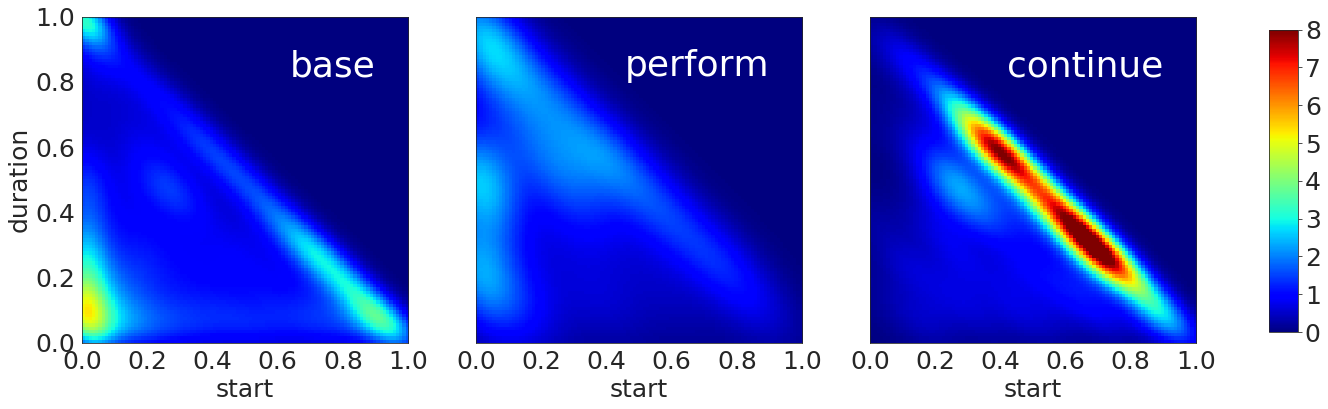

In [32]:
with mpl.rc_context(rc={'font.size': 25}):
    f, axes = plt.subplots(1, 3, figsize=(20, 6))
    axes = axes.ravel()
    for i, action in enumerate(['base', 'perform', 'continue']):
        kernel = segment_generator.kernels[action]
        if i==len(axes):
            break
        X, Y = np.mgrid[0:1:100j, 0:1:100j]
        positions = np.vstack([X.ravel(), Y.ravel()])
        Z = np.reshape(kernel(positions).T, X.shape)
        im = axes[i].imshow(np.rot90(Z), cmap=plt.cm.jet, extent=[0, 1, 0, 1], vmin=0, vmax=8)
        axes[i].text(0.9, 0.9, action, ha='right', va='top', color='w', fontsize=36)
        axes[i].grid(False)
        axes[i].set_xlabel('start')

        if i>0:
            axes[i].set_yticks([])
        else:
            axes[i].set_ylabel('duration')
            
    cbar_ax = f.add_axes([0.95, 0.15, 0.02, 0.7])#[left, bottom, width, height]
    f.colorbar(im, cax=cbar_ax)
    plt.savefig(f"reports/figures/dataset visualization/activitynet-moment-prior_(base,perform,continue).pdf", bbox_inches="tight")

In [102]:
# use all verbs

predictions = []
for instance in val_data[::10]:
    query, location = instance
    length = location[-1]
    
    actions, objects = sentence2token(query[1])
    
    if len(actions):
        n = 100 // len(actions)

        samples = []
        likelifood = []

        for action in actions:
            sample, score = segment_generator.sample(action, n)
            samples.append(sample)
            likelifood.append(score)

        samples = np.vstack(samples)
        likelifood = np.hstack(likelifood)
    else:
        samples, likelifood = segment_generator.sample("base", 100)
    
    bbox = samples.copy()
    bbox[:, 1] = bbox.sum(axis=1)

    keep = _nms(bbox, likelifood, 0.45)
    bbox = bbox[keep]
    likelifood = likelifood[keep]

    location = np.hstack([bbox * length, np.ones((len(bbox),1)) * length])
    
    predictions.append((query, location.tolist(), likelifood.tolist()))
    
    if len(predictions) % 1000 == 0:
        print(len(predictions))
        
results = evaluate(val_data[::10], predictions)
summary = accumulate_metrics(results)

1000
R@1 IoU>0.3 0.25
R@1 IoU>0.5 0.17
R@1 IoU>0.7 0.08
R@5 IoU>0.3 0.57
R@5 IoU>0.5 0.42
R@5 IoU>0.7 0.23
R@10 IoU>0.3 0.80
R@10 IoU>0.5 0.64
R@10 IoU>0.7 0.35


In [105]:
# use only first seen verb

predictions = []
for instance in val_data[::10]:
    query, location = instance
    length = location[-1]
    
    actions, objects = sentence2token(query[1])
    
    if len(actions):
        actions = [action for action in actions if action in segment_generator.vocab]
        action = actions[0] if len(actions) else "base"
        samples, likelifood = segment_generator.sample(action, 100)
    else:
        samples, likelifood = segment_generator.sample("base", 100)
    
    bbox = samples.copy()
    bbox[:, 1] = bbox.sum(axis=1)

    keep = _nms(bbox, likelifood, 0.45)
    bbox = bbox[keep]
    likelifood = likelifood[keep]

    location = np.hstack([bbox * length, np.ones((len(bbox),1)) * length])
    
    predictions.append((query, location.tolist(), likelifood.tolist()))
    
    if len(predictions) % 1000 == 0:
        print(len(predictions))

results = evaluate(val_data[::10], predictions)
summary = accumulate_metrics(results)

1000
R@1 IoU>0.3 0.30
R@1 IoU>0.5 0.19
R@1 IoU>0.7 0.10
R@5 IoU>0.3 0.56
R@5 IoU>0.5 0.41
R@5 IoU>0.7 0.23
R@10 IoU>0.3 0.78
R@10 IoU>0.5 0.61
R@10 IoU>0.7 0.34


In [125]:
from typing import Callable

def get_first_action(result: Result, action_vocab: List[str]) -> str:
    query, _, _, _ = result
    video_id, sentence = query
    actions, objects = sentence2token(sentence)
    
    if len(actions) == 0:
        action = "OoV"
    
    else:
        if actions[0] in action_vocab:
            action = actions[0] 
        else:
            action = "OoV"
    
    return action

def categorize_results(results: List[Result], cat_fn=Callable):
    keyed_results = {}
    for result in results:
        cls_label = cat_fn(result)
        keyed_results.setdefault(cls_label, []).append(result)
    return keyed_results

def summarize_results_per_class(keyed_results: dict) -> dict:
    metrics_per_cls = {}
    for cls_label, results in keyed_results.items():
        is_success = [metrics["R@1 IoU>0.5"] for _, _, _, metrics in results]
        n_success = sum(is_success)
        n_instance = len(is_success)
        rate_success = n_success / n_instance
        metrics_per_cls[cls_label] = {
            "n_success": n_success,
            "n_instance": n_instance,
            "rate_success": rate_success
        }
    return metrics_per_cls

def plot_performance_per_class(metrics_per_cls: dict) -> None:
    order = np.argsort([metrics["rate_success"] for metrics in metrics_per_cls.values()])[::-1]
    keys = list(metrics_per_cls.keys())
    n_success = list([metrics["n_success"] for metrics in metrics_per_cls.values()])
    n_instance = list([metrics["n_instance"] for metrics in metrics_per_cls.values()])
    
    keys = [keys[i] for i in order]
    n_success = [n_success[i] for i in order]
    n_instance = [n_instance[i] for i in order]

    N_cls = len(keys)

    fig, ax1 = plt.subplots(figsize=(25, 5))
    _ = plt.xticks(np.arange(n), keys, rotation=45, fontsize=18)

    ax1.bar(np.arange(N_cls), n_instance, color="coral", alpha=.7)
    ax1.bar(np.arange(N_cls), n_success, color="limegreen", alpha=1)

    ax2 = ax1.twinx()
    ax2.plot(np.arange(N_cls), np.asarray(n_success) / np.asarray(n_instance), color="blue")
    ax2.set_ylim(0, 1)

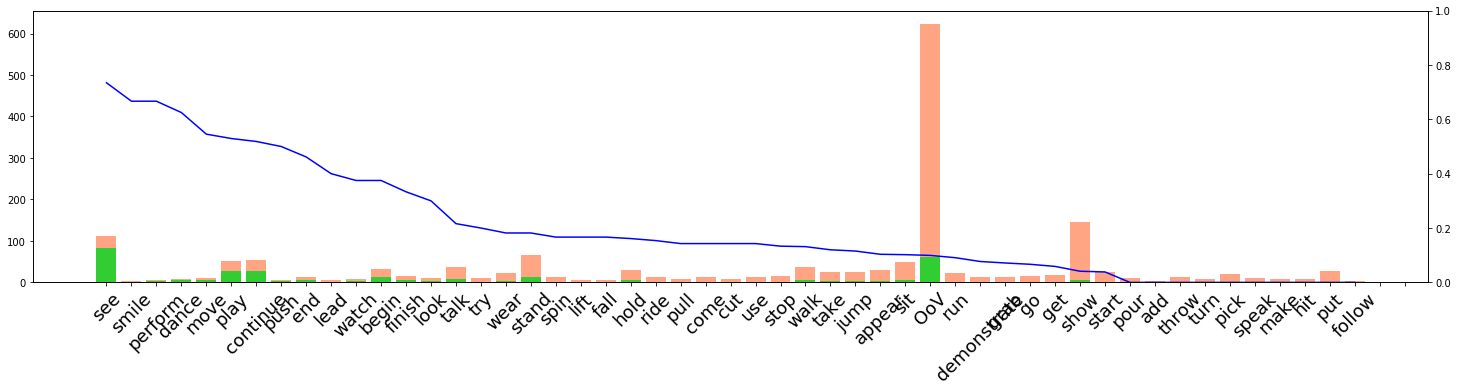

In [126]:
cat_fn = lambda x: get_first_action(x, segment_generator.vocab)
categorized_results = categorize_results(results, cat_fn)
metrics_per_cls = summarize_results_per_class(categorized_results)
plot_performance_per_class(metrics_per_cls)